In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms
import torchvision.utils
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 130653306.40it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43062813.30it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 147034003.67it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19782480.55it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Constructing the DataLoader

The PyTorch [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class is an efficient implementation of an iterator that can perform useful preprocessing and returns batches of elements. Here, we use its ability to batch and shuffle data, but DataLoaders are capable of much more.

Note that each time we iterate over a DataLoader, it starts again from the beginning.

Below we use `torchvision.utils.make_grid()` to show a sample batch of inputs.

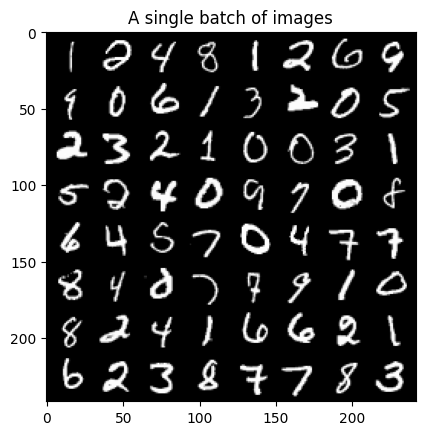

In [ ]:
data_loader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=True)

# Show one batch of images. Each batch of images has shape [batch_size, 1, 28, 28],
# where 1 is the "channels" dimension of the image.
for images,labels in data_loader:
    grid_img = torchvision.utils.make_grid(images)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("A single batch of images")
    break

### Defining the Network
Here we define a simple 1-hidden-layer neural network for classification on MNIST. It takes a parameter that determines the hidden size of the hidden layer.

In [ ]:
class MNISTNetwork(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear_0 = nn.Linear(784, hidden_size)
        self.linear_1 = nn.Linear(hidden_size, 10)

    def forward(self, inputs):
        x = self.linear_0(inputs)
        x = torch.sigmoid(x)
        return self.linear_1(x)

### Instantiating the Networks

We will consider three networks.

1. One that only has a single hidden unit and all of its weights are initialized to exactly 0.
2. One that has 64 hidden units and all of its weights are initialized to exactly 0.
3. One that has 64 hidden units and the weights are initialized using Torch's default, [Kaiming Uniform initialization](https://pytorch.org/docs/stable/nn.init.html).

In the code below, we utilize some important PyTorch methods which you'll want to be familiar with. This includes:

* [`torch.nn.Module.parameters()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html): Returns an iterator over module parameters (i.e. for passing to an optimizer that will update those parameters).

* [`torch.Tensor.view()`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html): Returns a *view* into the original Tensor. The result of this method shares the same underlying data as the input Tensor. This avoids copying the data, which means it can be mnore efficient, but it also means that when the original Tensor is modified, so is the view!

* [`torch.Tensor.item()`](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html#torch.Tensor.item): Returns the value of a single-element Tensor as a standard Python number. This only works for tensors with one element. For other cases, see `torch.Tensor.tolist()`.

* [`torch.Tensor.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html): Computes the gradients of current tensor wrt the graph leaves (note that this is only called if `Tensor.requires_grad` is True, which is the case by default). After calling this, a Tensor's `.grad` attribute is updated with the current gradients. These are used, for example, when calling `.step()` method of an optimizer.

* [`torch.optim.Optimizer.zero_grad()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html): Sets the gradients of all variables to zero. This should be conducted before each step of an optimization procedure (i.e., for each batch of training a DNN). If `.zero_grad()` is not called, gradients accumulate (add) over iterations.

In [ ]:
small_net = MNISTNetwork(1)
large_net = MNISTNetwork(64)
large_net_rand = MNISTNetwork(64)

In [ ]:
for p in zip(small_net.parameters(), large_net.parameters()):
    p1, p2 = p
    p1.data = torch.zeros_like(p1.data)
    p2.data = torch.zeros_like(p2.data)

### Training

We will train all three networks simulateneously using the same learning rate. After each epoch, we print the current loss of each network.

In [ ]:
epochs = 32

optimizer_small = optim.Adam(small_net.parameters(), lr=5e-3)
optimizer_large = optim.Adam(large_net.parameters(), lr=5e-3)
optimizer_large_rand = optim.Adam(large_net_rand.parameters(), lr=5e-3)

for i in range(epochs):
    loss_small_epoch = 0.
    loss_large_epoch = 0.
    loss_large_rand_epoch = 0.

    for batch in tqdm(data_loader):
        images, labels = batch
        images, labels = images, labels

        images = images.view(-1, 784)

        optimizer_small.zero_grad()
        optimizer_large.zero_grad()
        optimizer_large_rand.zero_grad()

        y_small = small_net(images)
        y_large = large_net(images)
        y_large_rand = large_net_rand(images)

        loss_small = F.cross_entropy(y_small, labels)
        loss_large = F.cross_entropy(y_large, labels)
        loss_large_rand = F.cross_entropy(y_large_rand, labels)

        loss_small_epoch += loss_small.item()
        loss_large_epoch += loss_large.item()
        loss_large_rand_epoch += loss_large_rand.item()

        loss_small.backward()
        loss_large.backward()
        loss_large_rand.backward()

        optimizer_small.step()
        optimizer_large.step()
        optimizer_large_rand.step()

    print("Small Loss:", loss_small_epoch / len(data_loader))
    print("Large Loss:", loss_large_epoch / len(data_loader))
    print("Large rand Loss:", loss_large_rand_epoch / len(data_loader))

100%|██████████| 938/938 [00:19<00:00, 48.14it/s]


Small Loss: 1.9686110031121828
Large Loss: 1.845996201927982
Large rand Loss: 0.3214661335743376


100%|██████████| 938/938 [00:10<00:00, 90.87it/s]


Small Loss: 1.7993601317853054
Large Loss: 1.6874540960356625
Large rand Loss: 0.14395835265906445


100%|██████████| 938/938 [00:10<00:00, 88.31it/s]


Small Loss: 1.7758303683703895
Large Loss: 1.6335801642332504
Large rand Loss: 0.10547258428879765


100%|██████████| 938/938 [00:10<00:00, 89.59it/s]


Small Loss: 1.7662797614709655
Large Loss: 1.6176004200093528
Large rand Loss: 0.08257077723991738


100%|██████████| 938/938 [00:09<00:00, 97.50it/s]


Small Loss: 1.762273775107825
Large Loss: 1.610123169701745
Large rand Loss: 0.0674928287123598


100%|██████████| 938/938 [00:10<00:00, 91.39it/s]


Small Loss: 1.7576717891926958
Large Loss: 1.607301989470972
Large rand Loss: 0.058055635164879056


100%|██████████| 938/938 [00:10<00:00, 89.85it/s]


Small Loss: 1.7534167016747155
Large Loss: 1.6036905333685723
Large rand Loss: 0.048721478180910174


100%|██████████| 938/938 [00:11<00:00, 83.49it/s]


Small Loss: 1.750211995166502
Large Loss: 1.5988632645179977
Large rand Loss: 0.04164094571247578


100%|██████████| 938/938 [00:10<00:00, 90.99it/s]


Small Loss: 1.7431044240496052
Large Loss: 1.5986251226112025
Large rand Loss: 0.03609448297297769


100%|██████████| 938/938 [00:10<00:00, 85.73it/s]


Small Loss: 1.7352350703688826
Large Loss: 1.5959446390808771
Large rand Loss: 0.03069798598874674


100%|██████████| 938/938 [00:10<00:00, 88.02it/s]


Small Loss: 1.7257215506486547
Large Loss: 1.5963406949155112
Large rand Loss: 0.02579616171693596


100%|██████████| 938/938 [00:10<00:00, 92.93it/s]


Small Loss: 1.716865579965018
Large Loss: 1.5985820299780953
Large rand Loss: 0.023863832087396012


100%|██████████| 938/938 [00:10<00:00, 90.84it/s]


Small Loss: 1.706327477497841
Large Loss: 1.5946030584988056
Large rand Loss: 0.02382473293377875


100%|██████████| 938/938 [00:10<00:00, 90.17it/s]


Small Loss: 1.6977974689845592
Large Loss: 1.5966023071996693
Large rand Loss: 0.018412654351657516


100%|██████████| 938/938 [00:10<00:00, 90.84it/s]


Small Loss: 1.6856787512297315
Large Loss: 1.5942094840728906
Large rand Loss: 0.018290380240050155


100%|██████████| 938/938 [00:10<00:00, 90.68it/s]


Small Loss: 1.6718603927951885
Large Loss: 1.5924226763660212
Large rand Loss: 0.017255681113209395


100%|██████████| 938/938 [00:09<00:00, 94.96it/s]


Small Loss: 1.6590746862293562
Large Loss: 1.5918660486684932
Large rand Loss: 0.015083817239106843


100%|██████████| 938/938 [00:09<00:00, 94.12it/s] 


Small Loss: 1.6508685333896547
Large Loss: 1.593221112482075
Large rand Loss: 0.011833151363443012


100%|██████████| 938/938 [00:10<00:00, 90.00it/s]


Small Loss: 1.6440107441151828
Large Loss: 1.593274991395377
Large rand Loss: 0.013981021019702241


100%|██████████| 938/938 [00:10<00:00, 90.52it/s]


Small Loss: 1.6365745919091361
Large Loss: 1.5911065196431775
Large rand Loss: 0.01256740825018783


100%|██████████| 938/938 [00:10<00:00, 89.35it/s]


Small Loss: 1.6318654518391786
Large Loss: 1.592463855677322
Large rand Loss: 0.01092388967224243


100%|██████████| 938/938 [00:10<00:00, 89.54it/s]


Small Loss: 1.6272762781267227
Large Loss: 1.5924176944852637
Large rand Loss: 0.009318025755268253


100%|██████████| 938/938 [00:09<00:00, 95.19it/s]


Small Loss: 1.6221415706789062
Large Loss: 1.5885658170114447
Large rand Loss: 0.011478952042045949


100%|██████████| 938/938 [00:10<00:00, 89.22it/s]


Small Loss: 1.61985241604258
Large Loss: 1.5921759061467673
Large rand Loss: 0.012132162012771439


100%|██████████| 938/938 [00:11<00:00, 84.38it/s]


Small Loss: 1.614136754958106
Large Loss: 1.5908348473912872
Large rand Loss: 0.008598706812262186


100%|██████████| 938/938 [00:10<00:00, 90.78it/s]


Small Loss: 1.6129024360479831
Large Loss: 1.5908719144904537
Large rand Loss: 0.00691674508885308


100%|██████████| 938/938 [00:10<00:00, 91.90it/s]


Small Loss: 1.6072270330081362
Large Loss: 1.590845467058072
Large rand Loss: 0.009986927930912838


100%|██████████| 938/938 [00:10<00:00, 89.96it/s]


Small Loss: 1.6039953299168586
Large Loss: 1.5893269121519793
Large rand Loss: 0.0077724518216669815


100%|██████████| 938/938 [00:10<00:00, 92.07it/s]


Small Loss: 1.6021939771515983
Large Loss: 1.591237175566301
Large rand Loss: 0.006375130910195316


100%|██████████| 938/938 [00:09<00:00, 95.82it/s]


Small Loss: 1.5981643137647146
Large Loss: 1.58761466604306
Large rand Loss: 0.010169061671632259


100%|██████████| 938/938 [00:10<00:00, 90.04it/s] 


Small Loss: 1.5959466474651018
Large Loss: 1.5895942740603042
Large rand Loss: 0.009810188622269749


100%|██████████| 938/938 [00:10<00:00, 89.62it/s]

Small Loss: 1.594366220777223
Large Loss: 1.5886052759217302
Large rand Loss: 0.007317984162841979


In [ ]:
W_0 = large_net.linear_0.weight
b_0 = large_net.linear_0.bias

W_1 = large_net.linear_1.weight
b_1 = large_net.linear_1.bias

In [ ]:
print("W_0 => All weights equal for each hidden unit:", (W_0[0, :].unsqueeze(0) == W_0).all().item())
print("Example of weights:")
print(W_0[:, 256])

W_0 => All weights equal for each hidden unit: True
Example of weights:
tensor([0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776,
        0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776,
        0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776,
        0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776,
        0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776,
        0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776,
        0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776, 0.2776,
        0.2776], grad_fn=<SelectBackward0>)


In [ ]:
print("W_1 => All weights equal for each hidden unit:", (W_1[:, 0].unsqueeze(-1) == W_1).all().item())
print("Weights:")
print(W_1[8])

W_1 => All weights equal for each hidden unit: True
Weights:
tensor([-0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440,
        -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440,
        -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440,
        -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440,
        -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440,
        -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440,
        -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440,
        -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440, -0.0440],
       grad_fn=<SelectBackward0>)


In [ ]:
print("b_0 => All biases equal for each hidden unit:", (b_0[0] == b_0).all().item())
print("Bias:")
print(b_0)

b_0 => All biases equal for each hidden unit: True
Bias:
Parameter containing:
tensor([-0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328,
        -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328,
        -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328,
        -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328,
        -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328,
        -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328,
        -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328,
        -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328, -0.7328],
       requires_grad=True)


In [ ]:
print("b_1 => All biases equal for each hidden unit:", (b_1[0] == b_1).all().item())
print("Bias:")
print(b_1)

b_1 => All biases equal for each hidden unit: False
Bias:
Parameter containing:
tensor([ 2.4697, -9.1278, -3.1486,  0.5709,  2.9386,  1.6011, -1.6651,  4.0010,
         0.4965,  3.9294], requires_grad=True)


## Tensor and Layer sizes

Below is an implementation of the network from the section handout. We use `torchinfo-summary()` to view the size of the data as it flows through the network; additionally, we print and the size of the weights and biases of the layers during a forward pass. Note that this network is just for demonstration and may not work well in practice.

*Note:* this section uses the [`torchinfo`](https://github.com/TylerYep/torchinfo) package; see the github repo for installation instructions or run one of the following lines below:

*install via conda*:
```
conda install -c conda-forge torchinfo
```

*install via pip*:
```
pip install torchinfo
```

In [ ]:
from torchinfo import summary

class DemoNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.max1 = nn.MaxPool2d(2, 2, 0)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 0)
        self.max2 = nn.MaxPool2d(2, 2, 1)
        self.conv3 = nn.Conv2d(32, 8, 1, 1, 0)
        self.conv4 = nn.Conv2d(8, 4, 5, 1, 0)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(36, 10)

    @property
    def trainable_layers(self):
        """A utility property to easily access a list of all model layers."""
        return [self.conv1, self.conv2, self.conv3, self.conv4, self.linear1]

    def forward(self, inputs):
        """Implements the forward pass."""
        x = self.conv1(inputs)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.linear1(x)
        return x

    def print_weight_shapes(self):
        """Utility function to print the shapes of weights in trainable layers."""
        for layer in self.trainable_layers:
            print(f"Weight shape: {layer.weight.shape}; Bias shape: {layer.bias.shape}")

demo = DemoNetwork()
batch_size = 64
summary(demo, input_size=(batch_size, 1, 28, 28))


ModuleNotFoundError: ignored

In [ ]:
demo.print_weight_shapes()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, test_data = torch.utils.data.random_split(mnist, [0.9, 0.1])
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

epochs = 16
optimizer = optim.Adam(demo.parameters(), lr=5e-3)

for i in range(epochs):
    loss = 0.
    correct_labels = 0
    total_labels = 0

    for batch in tqdm(train_dataloader):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        y_hat = demo(images)
        batch_loss = F.cross_entropy(y_hat, labels)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        correct_labels += torch.sum(torch.argmax(y_hat, dim=1) == labels).item()
        total_labels += len(labels)

    print("Train Loss:", loss / len(data_loader))
    print("Train Accuracy:", correct_labels / total_labels)


In [ ]:
with torch.no_grad():
    loss = 0.
    correct_labels = 0
    total_labels = 0
    for batch in tqdm(test_dataloader):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        y_hat = demo(images)
        batch_loss = F.cross_entropy(y_hat, labels)

        loss += batch_loss.item()
        correct_labels += torch.sum(torch.argmax(y_hat, dim=1) == labels).item()
        total_labels += len(labels)

    print("Test Loss:", loss / len(data_loader))
    print("Test Accuracy:", correct_labels / total_labels)